<a href="https://colab.research.google.com/github/vimuth97/Pump-It-Up/blob/main/pump_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [ ]:
train_data.head()
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Checking whether the dataset is balanced or not

In [ ]:
print(train_data['Survived'].value_counts(normalize=True))

0    0.616162
1    0.383838
Name: Survived, dtype: float64


In [ ]:
train_data.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

Drop 2 rows with missing values for 'Embarked' because carrying out imputation for 2 records is not efficient and may add errors to the prediction 

In [ ]:
tot = train_data.shape[0]
train_data.dropna(inplace=True, subset=['Embarked'])    # drop rows with null values for Embarked attribute
print(tot - train_data.shape[0], "rows removed")

2 rows removed


In [ ]:
Y = train_data.Survived
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]     #some features due to high cardinality and low relavnce
X = train_data[features]

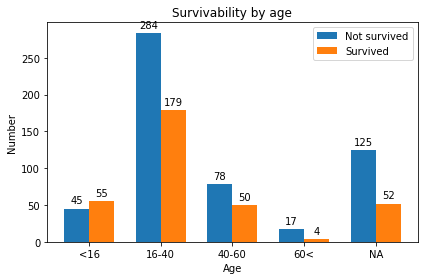

In [ ]:
# Visualise survivability w.r.t. Age
labels = ['<16', '16-40', '40-60', '60<', 'NA']
not_survived = [len(train_data[(train_data['Age']<=16) & (train_data['Survived']==0) & (train_data['Age']>0)]),
            len(train_data[(train_data['Age']>16) & (train_data['Survived']==0) & (train_data['Age']<=40)]),
            len(train_data[(train_data['Age']>40) & (train_data['Survived']==0) & (train_data['Age']<=60)]),
            len(train_data[(train_data['Age']>60) & (train_data['Survived']==0)]),
                len(train_data[np.isnan(train_data['Age']) & (train_data['Survived']==0)])]
survived = [len(train_data[(train_data['Age']<=16) & (train_data['Survived']==1) & (train_data['Age']>0)]),
            len(train_data[(train_data['Age']>16) & (train_data['Survived']==1) & (train_data['Age']<=40)]),
            len(train_data[(train_data['Age']>40) & (train_data['Survived']==1) & (train_data['Age']<=60)]),
            len(train_data[(train_data['Age']>60) & (train_data['Survived']==1)]),
            len(train_data[np.isnan(train_data['Age']) & (train_data['Survived']==1)])]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, not_survived, width, label='Not survived')
rects2 = ax.bar(x + width/2, survived, width, label='Survived')

ax.set_ylabel('Number')
ax.set_xlabel('Age')
ax.set_title('Survivability by age')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

 Imputing Age with mean value was less accurate compared to imputing with a constant.
 60 was selected observing the above graph NA and 60< has rate of survability

In [ ]:
# impute Age and Cabin

X['Cabin'].fillna('Missing', inplace=True) 
# X['Age'].fillna(round((X['Age'].mean()),2), inplace=True)    # impute Age with mean
X['Age'].fillna(60, inplace=True)    # imput Age with a constant

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
X_1 = pd.get_dummies(X.Sex)         # one hot encode column 'Sex'
X_2 = pd.get_dummies(X.Embarked, prefix="Embarked")    # one hot encode column 'Embarked'

In [ ]:
# reduce cardinality of Cabin
X_3 = pd.DataFrame()

X_3["CabinSClass"] = X.Cabin.str[0]
X_3["CabinSClass"].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [ ]:
X_dropped = X.drop(['Sex', 'Embarked', 'Cabin'], axis=1)
X_new = X_dropped.join([X_1, X_2, X_3])

In [ ]:
# Label encoding for CabinSClass
for colname in X_new.select_dtypes("object"):
    X_new[colname], _ = X_new[colname].factorize()

In [ ]:
# Utility functions from Tutorial
def make_mi_scores(X, y, features):
    X_mi = X.copy()
    mi_scores = mutual_info_classif(X_mi, y, discrete_features=features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Tried categorizing according to age but it caused less mutual information score and less test accuracy.

In [ ]:
# # Categorise by age limit 16
# X_new.loc[X_new.Age<=16, 'Age'] = 1
# X_new.loc[X_new.Age>16, 'Age'] = 0

female         0.149725
male           0.149725
Fare           0.135438
Pclass         0.057127
CabinSClass    0.053768
Age            0.042631
SibSp          0.023490
Parch          0.016653
Embarked_C     0.014079
Embarked_S     0.011335
Embarked_Q     0.000010
Name: MI Scores, dtype: float64


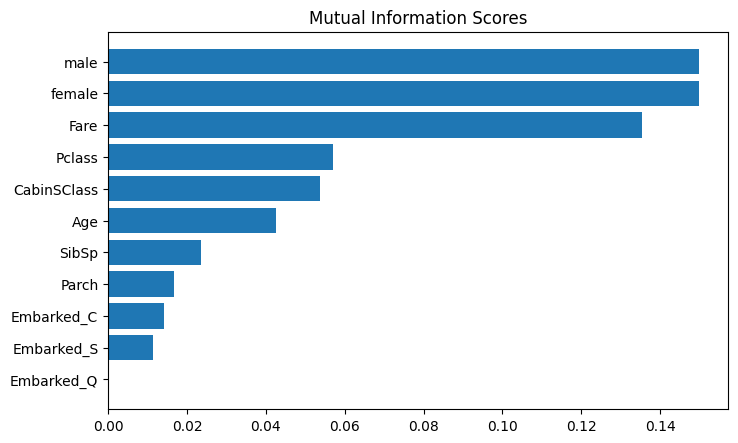

In [ ]:
# mutual inofrmation
features = [True, False, True, True, False,True, True, True, True, True, True ]
mi_scores = make_mi_scores(X_new, Y, features)
print(mi_scores.head(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))


In [ ]:
X_mi = X_new.drop(['Embarked_Q'], axis=1) # remove Embarked_Q feature due to low mutual information score

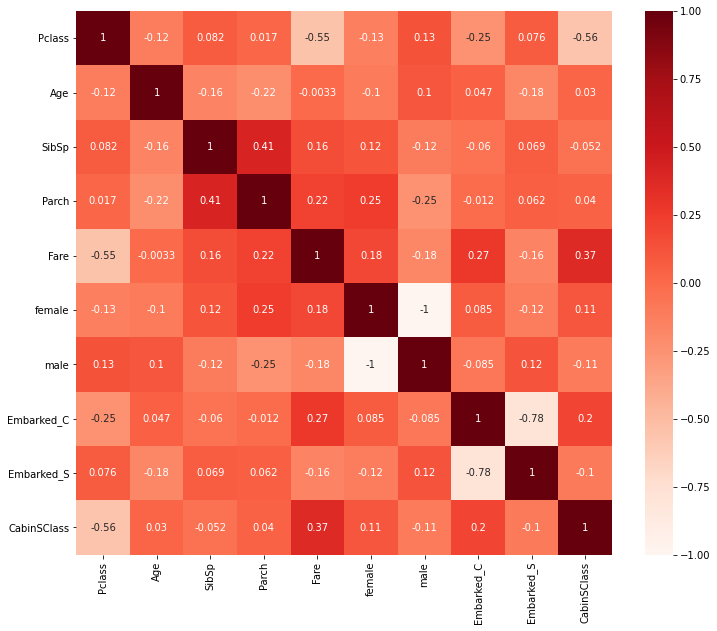

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_mi.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
X_cor = X_mi.drop(['male'], axis=1) # remove 'male' feature due to high correlation

In [ ]:
test_data.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

In [ ]:
# preprocess test data
test_1 = pd.get_dummies(test_data.Sex)
test_2 = pd.get_dummies(test_data.Embarked, prefix="Embarked")
test_data['Cabin'].fillna('Missing', inplace=True)
test_data['Fare'].fillna(0, inplace=True)

#impute and categorise Age
test_data['Age'].fillna(60, inplace=True)
# test_data.loc[test_data.Age<=16, 'Age'] = 1
# test_data.loc[test_data.Age>16, 'Age'] = 0

temp = pd.DataFrame()
temp["CabinSClass"] = test_data.Cabin.str[0]

cabin_map = ['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']
test_3 = temp["CabinSClass"].replace(to_replace=cabin_map, value=[0, 1, 2, 3,4, 5, 6, 7, 8])

test_new = test_data.join([test_1, test_2, test_3])
test_dropped = test_new.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'male', 'Embarked_Q', 'Embarked'], axis=1)

In [ ]:
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X_cor, Y, test_size=0.2, random_state=0)

In [ ]:
# GridSearch for random forest classifier
param_grid = {
    'bootstrap': [True],
    'criterion': ['entropy'],
    'max_depth': [10, 20, 50],
    'max_features': [8, 9],
    'min_samples_leaf': [2,3],
    'min_samples_split': [12, 14],
    'n_estimators': [32, 48],
}
num_folds = 10
# Create a base model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = num_folds, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
# grid_search.fit(X_cor, Y)  # for submission
grid_search.best_params_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   20.2s finished


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 14,
 'n_estimators': 48}

In [ ]:
model = grid_search.best_estimator_

In [ ]:
# cross validation
scoring = ['f1']
scores = cross_validate(model, X_train, y_train,scoring=scoring, cv=num_folds, return_train_score=True)
print("%0.4f train F1 score with a standard deviation of %0.4f" % (scores['train_f1'].mean(), scores['train_f1'].std()))
print("%0.4f test F1 score with a standard deviation of %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))

0.8652 train F1 score with a standard deviation of 0.0086
0.7620 test F1 score with a standard deviation of 0.0710


In [ ]:
y_pred = model.predict(X_test)

# evaluation
print(confusion_matrix(y_test,y_pred).ravel())
print(classification_report(y_test,y_pred))
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 Score :', f1_score(y_test, y_pred))

[91 14 26 47]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       105
           1       0.77      0.64      0.70        73

    accuracy                           0.78       178
   macro avg       0.77      0.76      0.76       178
weighted avg       0.77      0.78      0.77       178

Accuracy : 0.7752808988764045
F1 Score : 0.7014925373134328


In [ ]:
# save predictions for test set
y_pred = model.predict(test_dropped)
results = pd.DataFrame()
results["PassengerId"] = test_data.PassengerId
results["Survived"] = y_pred
results.to_csv('output37.csv', index=False)